<a href="https://colab.research.google.com/github/URLbug/Omega_Transformers/blob/main/Omega_Transformer_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.7.0.84-1+cuda11.8
!pip uninstall -y -q tensorflow-estimator tensorflow-text
!pip install -U tensorflow-text
!pip install datasets

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 7 not upgraded.
Need to get 463 MB of archives.
After this operation, 1,290 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8 8.7.0.84-1+cuda11.8 [463 MB]
Fetched 463 MB in 9s (49.1 MB/s)
(Reading database ... 120493 files and directories currently installed.)
Removing libcudnn8-dev (8.9.0.131-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.9.0.131-1+cuda11.8 to 8.7.0.84-1+cuda11.8
(Reading database ... 120460 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.7.0

In [30]:
import keras

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_text as text
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Input, Flatten
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from datasets import load_dataset

from datetime import datetime

In [3]:
crd3 = load_dataset("crd3")

Generating train split:   0%|          | 0/38969 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6327 [00:00<?, ? examples/s]

In [4]:
df = [i.to_pandas() for i in crd3.values()]

df = pd.concat(df, axis=0)

In [5]:
df.head()

,chunk,chunk_id,turn_start,turn_end,alignment_score,turns
0,Matthew Mercer introduces himself and the conc...,0,0,0,0.000000,"[{'names': ['MATT'], 'utterances': ['Hello eve..."
1,Matt explains how their eight-player game has ...,1,0,21,0.498612,"[{'names': ['MATT'], 'utterances': ['Hello eve..."
2,Donations will be accepted in the following we...,2,21,22,1.078358,"[{'names': ['MATT'], 'utterances': ['Well, gre..."
3,Marisha Ray explains how 826LA helps children ...,3,22,23,1.280000,"[{'names': ['MARISHA'], 'utterances': ['Yes! 8..."
4,The cast introduce themselves and their roles:...,4,23,24,0.196787,"[{'names': ['MATT'], 'utterances': ['Yes. Also..."


In [6]:
df.isna().sum()

chunk              0
chunk_id           0
turn_start         0
turn_end           0
alignment_score    0
turns              0
dtype: int64

<ipython-input-7-f9bae3447ea4>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[cols].corr(),


<Axes: >

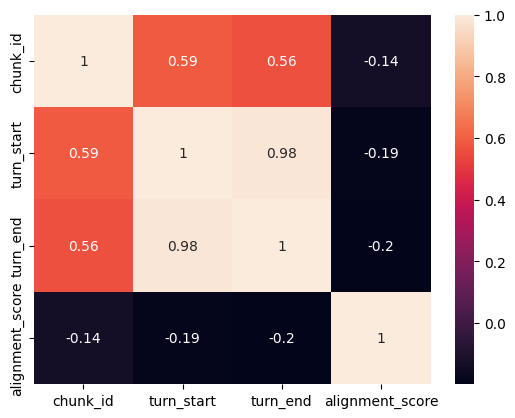

In [7]:
cols = ['chunk',	'chunk_id',	'turn_start',	'turn_end',	'alignment_score',	'turns']

sns.heatmap(df[cols].corr(),
            cbar=True,
            annot=True)

In [8]:
turns = [f"{' '.join(i[0]['utterances'])}" for i in df["turns"]]

In [9]:
chunk = [i for i in df["chunk"]]

In [10]:
X = chunk
y = turns

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

dataset_2 = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [13]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [14]:
tokenizers = tf.saved_model.load(model_name)

In [15]:
def tokenize_pairs(en, en_2):
    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()

    en_2 = tokenizers.en.tokenize(en_2)
    # Convert from ragged to dense, padding with zeros.
    en_2 = en_2.to_tensor()
    return en, en_2

In [16]:
MAX_LENGTH = 128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def prepare_batch(en, en_2):
    en = tokenizers.en.tokenize(en)      # Output is ragged.
    en = en[:, :MAX_LENGTH]    # Trim to MAX_TOKENS.
    en = en.to_tensor()  # Convert to 0-padded dense Tensor

    en_2 = tokenizers.en.tokenize(en_2)
    en_2 = en_2[:, :(MAX_LENGTH+1)]
    en_inputs = en_2[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en_2[:, 1:].to_tensor()   # Drop the [START] tokens

    return (en, en_inputs), en_labels

def make_batches(ds):
  return ds.cache()\
  .shuffle(BUFFER_SIZE)\
  .batch(BATCH_SIZE)\
  .map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE)\
  .prefetch(tf.data.AUTOTUNE)


train_dataset = make_batches(dataset)
test_dataset = make_batches(dataset_2)

In [17]:
for i in train_dataset.take(3):
  print(i)

((<tf.Tensor: shape=(64, 128), dtype=int64, numpy=
array([[   2,   71,  518, ...,    0,    0,    0],
       [   2,   58, 3895, ...,    0,    0,    0],
       [   2,   83, 2190, ...,    0,    0,    0],
       ...,
       [   2,   43, 1548, ...,    0,    0,    0],
       [   2,   76,  546, ...,    0,    0,    0],
       [   2,   83,  731, ...,    0,    0,    0]])>, <tf.Tensor: shape=(64, 128), dtype=int64, numpy=
array([[   2,   81,  431, ...,   71,   43,  690],
       [   2,  679, 3074, ...,    0,    0,    0],
       [   2, 1287,   88, ...,    0,    0,    0],
       ...,
       [   2,  525,   13, ...,    0,    0,    0],
       [   2,   37, 5180, ...,    0,    0,    0],
       [   2,  221,  887, ..., 3284, 2788,  171]])>), <tf.Tensor: shape=(64, 128), dtype=int64, numpy=
array([[  81,  431,   92, ...,   43,  690,   13],
       [ 679, 3074,  459, ...,    0,    0,    0],
       [1287,   88,   15, ...,    0,    0,    0],
       ...,
       [ 525,   13,   45, ...,    0,    0,    0],
       [

In [18]:
def mask(seq):
  return tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

def mask_final(size):
  return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

In [19]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
x_ = tf.random.uniform((1, 3))

mask(x), mask_final(x_.shape[1])

(<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
 array([[[[0., 0., 1., 1., 0.]]],
 
 
        [[[0., 0., 0., 1., 1.]]],
 
 
        [[[1., 1., 1., 0., 0.]]]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]], dtype=float32)>)

In [20]:
class PositionalFF(keras.layers.Layer):
  def __init__(self, d_model, diff):
    super(PositionalFF, self).__init__()

    self.model = keras.Sequential([
        Dense(diff, activation='relu'),
        Dense(d_model)
    ])

  def call(self, x):
    return self.model(x)

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoder(i, d_model):
  angle_rads = get_angles(np.arange(i)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

class Add_and_Norm(keras.layers.Layer):
  def __init__(self, dropout, epsilon=1e-6):
    super(Add_and_Norm, self).__init__()

    self.add = Dropout(dropout)
    self.norm = keras.layers.LayerNormalization(epsilon=epsilon)

  def call(self, x, y):
    return self.norm(self.add(x) + y)

class Encoder_Layer(keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(Encoder_Layer, self).__init__()

    self.multihead = keras.layers.MultiHeadAttention(num_heads, d_model)
    self.add_norm = Add_and_Norm(rate)
    self.positional_ff = PositionalFF(d_model ,dff)
    self.add_norm_2 = Add_and_Norm(rate)

  def call(self, x):
    multiheads, _ = self.multihead(x, x, x, use_causal_mask = True, return_attention_scores=True)
    addnorm = self.add_norm(multiheads, x)
    pos_ff = self.positional_ff(addnorm)
    x = self.add_norm_2(pos_ff, addnorm)

    return x

class Transformers_Encoder(keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Transformers_Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embeding = Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoder(maximum_position_encoding,
                                            self.d_model)

    self.encoder_layer = [Encoder_Layer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x):
    b = tf.shape(x)[1]
    x = self.embeding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, dtype=tf.float32))
    x = x + self.pos_encoding[:, :b, :]

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.encoder_layer[i](x)

    return x

In [21]:
class Decoder_Layer(keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(Decoder_Layer, self).__init__()

    self.multihead = keras.layers.MultiHeadAttention(num_heads, d_model)
    self.multihead_2 = keras.layers.MultiHeadAttention(num_heads, d_model)

    self.add_norm = Add_and_Norm(rate)
    self.positional_ff = PositionalFF(d_model, dff)
    self.add_norm_2 = Add_and_Norm(rate)
    self.add_norm_3 = Add_and_Norm(rate)

  def call(self, x):
    multiheads, attention = self.multihead(x[0], x[0], x[0], return_attention_scores=True, use_causal_mask = True)

    addnorm = self.add_norm(multiheads, x[0])

    multihead_2, attention_2 = self.multihead_2(addnorm, x[1], x[1], return_attention_scores=True, use_causal_mask = True)

    addnorm_2 = self.add_norm_2(multihead_2, addnorm)

    pos_ff = self.positional_ff(addnorm_2)

    x[0] = self.add_norm_3(pos_ff, addnorm_2)

    return x[0], attention, attention_2

class Transformer_Decoder(keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Transformer_Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_encoding = positional_encoder(maximum_position_encoding, d_model)

    self.embeding = Embedding(maximum_position_encoding, d_model)

    self.decoder_layer = [Decoder_Layer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x):
    b = tf.shape(x[0])[1]

    attention_w = {}

    x_ = self.embeding(x[0])
    x_ *= tf.math.sqrt(tf.cast(self.d_model, dtype=tf.float32))
    x_ = x_ + self.pos_encoding[:, :b, :]

    x_ =  self.dropout(x_)

    for i in range(self.num_layers):
      x_, block1, block2 = self.decoder_layer[i]([x_, x[1]])

      attention_w[f'decoder_layer{i+1}_block1'] = block1
      attention_w[f'decoder_layer{i+1}_block2'] = block2

    return x_, attention_w

In [22]:
sample_encoder = Transformers_Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [23]:
sample_decoder = Transformer_Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder([temp_input, sample_encoder_output],
                              training=False)

print(output.shape, attn['decoder_layer2_block2'].shape)

(64, 26, 512) (64, 8, 26, 62)


In [24]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = .1

class Transformer(Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()
    self.encoder = Transformers_Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Transformer_Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.dense = Dense(target_vocab_size)


  def create_masks(self, inp, tar):
    enc_padding_mask = mask(inp)

    dec_padding_mask = mask(inp)

    look_ahead_mask = mask_final(tf.shape(tar)[1])
    dec_target_padding_mask = mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

  def call(self, inputs):
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x, _ = self.decoder([x, context])  # (batch_size, target_len, d_model)

    logits = self.dense(x)  # (batch_size, target_len, target_vocab_size)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [25]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=50):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.en.tokenize(sentence).to_tensor()

    encoder_input = sentence

    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens


translator = Translator(tokenizers, transformer)

translated_text, translated_tokens = translator(
    tf.constant('sentence'))
translated_text

<tf.Tensor: shape=(), dtype=string, numpy=b'cheap sustainedridge pantsges sure skull race race counted counted race race raceographicographicographic administration counted counted counted race race newton newton newton nanopatch officer race race race race newton newton newton produce hat full bought full bought newton newton newtonically fullically produce produce produce'>

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)

    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,

     }
    return config

lr = CustomSchedule(d_model, 4000)

optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9) # 3e-5

In [27]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [28]:
model = transformer.fit(train_dataset,
                epochs=50, validation_data=test_dataset)

Epoch 1/50
660/660 [==============================] - 357s 477ms/step - loss: 6.8644 - masked_accuracy: 0.0704 - val_loss: 5.2971 - val_masked_accuracy: 0.1489
Epoch 2/50
660/660 [==============================] - 267s 404ms/step - loss: 4.8442 - masked_accuracy: 0.1776 - val_loss: 4.4004 - val_masked_accuracy: 0.2137
Epoch 3/50
660/660 [==============================] - 262s 397ms/step - loss: 4.2175 - masked_accuracy: 0.2280 - val_loss: 3.8762 - val_masked_accuracy: 0.2676
Epoch 4/50
660/660 [==============================] - 259s 393ms/step - loss: 3.7901 - masked_accuracy: 0.2729 - val_loss: 3.4731 - val_masked_accuracy: 0.3212
Epoch 5/50
660/660 [==============================] - 259s 392ms/step - loss: 3.4700 - masked_accuracy: 0.3152 - val_loss: 3.1847 - val_masked_accuracy: 0.3655
Epoch 6/50
660/660 [==============================] - 242s 366ms/step - loss: 3.2461 - masked_accuracy: 0.3481 - val_loss: 2.9821 - val_masked_accuracy: 0.3987
Epoch 7/50
660/660 [====================

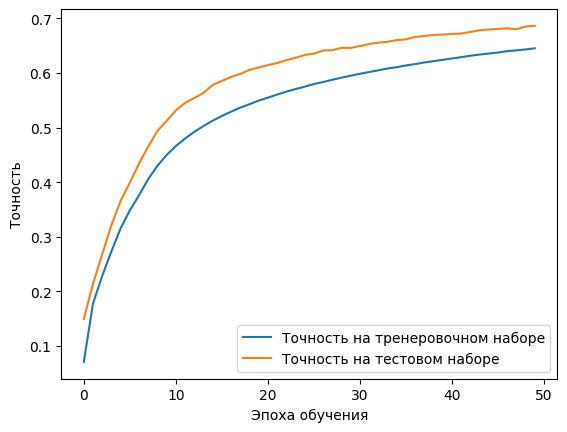

In [31]:
plt.plot(model.history['masked_accuracy'],
         label='Точность на тренеровочном наборе')
plt.plot(model.history['val_masked_accuracy'],
         label='Точность на тестовом наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [32]:
for i in range(5):
  translated_text, _ = translator(tf.constant(X_test[i]), 100)

  print(f'Ответ нейросети: {translated_text}')
  print('Ожидаемый ответ: ' + y_test[i])

Ответ нейросети: b"i ' m going to flip out my bottle and co out my hand and try to give it some love the keys ."
Ожидаемый ответ: Loot Crate has donated two Loot Crate DX boxes to give away to you. We will be doing this at the break and at the end of the night, random in chat. You must be active! Stay tuned for that! Exclamation point!
Ответ нейросети: b"i ' m going to be at emconond ."
Ожидаемый ответ: Well, how much of them lived? It's Barovia, to be fair. Anyway, welcome. Before we hop into tonight's game, we have some announcements to get through. First and foremost, I believe, if Sam is ready, it looks like he's stretching himself. We have our fantastic sponsor, for campaign two since day one, our friends at D&D Beyond.
Ответ нейросети: b"i ' m going to take a quick and i ' m going to take a big break and i ' m going to use my action to try and get him in the la ."
Ожидаемый ответ: A giant glob of magma pours down and splashes down onto the ground, hitting everyone in the vicinity

In [34]:
while True:
  inp = input('You - ')

  if inp.lower() == 'break':
    break

  print(translator(tf.constant(inp), 50)[0])

You - hello
tf.Tensor(b"i ' m going to take a quick . i ' m going to go straight and take a quick on the door and i sit out of the door and i sit out my hand out of the door and i ' m going to walk out my hand", shape=(), dtype=string)
You - break
